In [30]:
import numpy as np
from tifffile import imread
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
tracks = np.genfromtxt(r"Y:\Eric\prediction_test\data\interim\tracking\TrackMatetracks_3dl.csv", delimiter=',', skip_header=1)

In [22]:
tracks

array([[  0.,   5.,  10., 238., 238.],
       [  0.,  10.,  10., 239., 234.],
       [  0.,  15.,  11., 240., 234.],
       ...,
       [268., 480.,  24., 221., 189.],
       [269., 480.,  23., 264., 206.],
       [270., 480.,  24., 180., 178.]])

In [23]:
tracks[:, 1] = tracks[:, 1]/ 5 

In [25]:
import pandas as pd
df = pd.DataFrame(tracks, columns=['track_id', 'frame', 'z', 'y', 'x'])

In [86]:
df['seg_id'] = -1

In [87]:
df

,track_id,frame,z,y,x,volume,seg_id
0,0.0,1.0,10.0,238.0,238.0,1,-1
1,0.0,2.0,10.0,239.0,234.0,1,-1
2,0.0,3.0,11.0,240.0,234.0,1,-1
3,0.0,4.0,11.0,241.0,234.0,1,-1
4,0.0,5.0,11.0,241.0,233.0,1,-1
...,...,...,...,...,...,...,...
1501,266.0,96.0,18.0,265.0,191.0,-1,-1
1502,267.0,96.0,21.0,192.0,259.0,-1,-1
1503,268.0,96.0,24.0,221.0,189.0,-1,-1
1504,269.0,96.0,23.0,264.0,206.0,-1,-1


In [123]:
from pathlib import Path

# better approach: go through time and add volume information at the end:

root_path = Path(r"Y:\Eric\prediction_test\predictions")


for frame in tqdm(df['frame'].unique()):
    filename = f'kdv1502R_5L_30ms_300gain002_pos5_ch1_frame{int(frame+1):06d}_Nz54P.tif'
    im = imread(str(root_path / filename))
    
    belongs_to_frame = df['frame'] == frame
    df_ = df[['z', 'y', 'x']][belongs_to_frame]
    values = df_.values.astype('int') * 2
    z = values[:, 0]
    y = values[:, 1]
    x = values[:, 2]
    
    label_ = im[z, y, x]
    df.at[belongs_to_frame, 'seg_id'] = label_
    
    props = regionprops(im)
    area = np.asarray([p.area for p in props])
    
    _, inv_order = np.unique(label_, return_inverse=True)
    df.at[belongs_to_frame, 'volume'] = area[inv_order]

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [04:23<00:00,  2.72s/it]


In [124]:
df

,track_id,frame,z,y,x,volume,seg_id
0,0.0,1.0,10.0,238.0,238.0,2000,1
1,0.0,2.0,10.0,239.0,234.0,2088,1
2,0.0,3.0,11.0,240.0,234.0,2021,1
3,0.0,4.0,11.0,241.0,234.0,2228,1
4,0.0,5.0,11.0,241.0,233.0,2089,1
...,...,...,...,...,...,...,...
1501,266.0,96.0,18.0,265.0,191.0,1336,31
1502,267.0,96.0,21.0,192.0,259.0,1686,42
1503,268.0,96.0,24.0,221.0,189.0,976,82
1504,269.0,96.0,23.0,264.0,206.0,1226,6


In [147]:
output_name = Path(r'data\processed\track_data.csv')

import os

if not output_name.parent.is_dir():
    os.makedirs(output_name.parent)

In [148]:
df.to_csv(output_name)

<IPython.core.display.Javascript object>


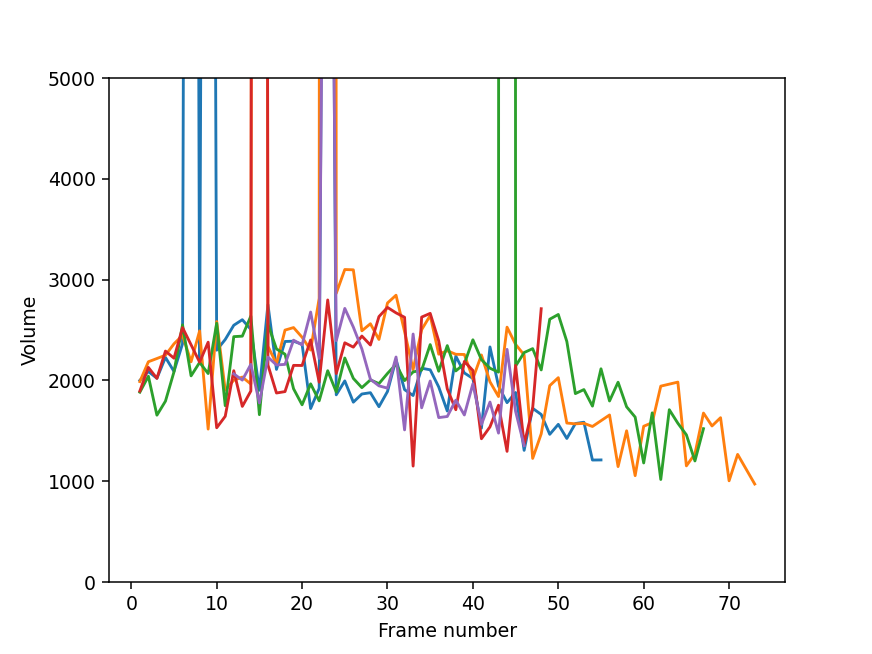

In [156]:
f, ax = plt.subplots()


for t_id in df['track_id'].unique()[:5]:
    df_ = df[['frame', 'volume']][(df['track_id'] == t_id) & (df['seg_id'] != 0)]

    ax.plot(df_['frame'], df_['volume'])
    
ax.set_ylim(0, 5000)
ax.set_xlabel('Frame number')
ax.set_ylabel('Volume')

output_name = Path(r'reports\figures\track_Volume_over_FrameNumber.pdf')

if not output_name.parent.is_dir():
    os.makedirs(output_name.parent)

f.savefig(output_name)